In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Process

## Price

Source: https://www.smard.de/home/downloadcenter/download-marktdaten/

In [159]:
file_path = '0_raw/Gro_handelspreise_201507010000_201807010000_Stunde.csv'
raw_df = pd.read_csv(file_path, sep=';', header=0, converters={'DE/AT/LU [€/MWh] Originalauflösungen': lambda x: float(x.replace(",", "."))})
raw_values = raw_df['DE/AT/LU [€/MWh] Originalauflösungen']
timestep_raw_values = pd.Series([x/100 for x in raw_values for _ in range(2)]).round(4)

start = datetime(2015, 7, 1, 0, 30)
end = datetime(2018, 7, 1, 0, 0)
dates = pd.date_range(start, end, freq='30min')

price = pd.DataFrame({'Date': dates, 'Price': timestep_raw_values}, columns=['Date', 'Price'])

start = datetime(2016, 2, 29, 0, 30) 
end = datetime(2016, 3, 1, 0, 0)
remove = pd.date_range(start, end, freq='30min')
price_wo_leap = price[~price['Date'].isin(remove)]

price_wo_leap.to_csv('1_processed/price.csv', index=False)
price_wo_leap

,Date,Price
0,2015-07-01 00:30:00,0.3062
1,2015-07-01 01:00:00,0.3062
2,2015-07-01 01:30:00,0.2998
3,2015-07-01 02:00:00,0.2998
4,2015-07-01 02:30:00,0.2805
...,...,...
52603,2018-06-30 22:00:00,0.4751
52604,2018-06-30 22:30:00,0.4780
52605,2018-06-30 23:00:00,0.4780
52606,2018-06-30 23:30:00,0.4396


<Axes: >

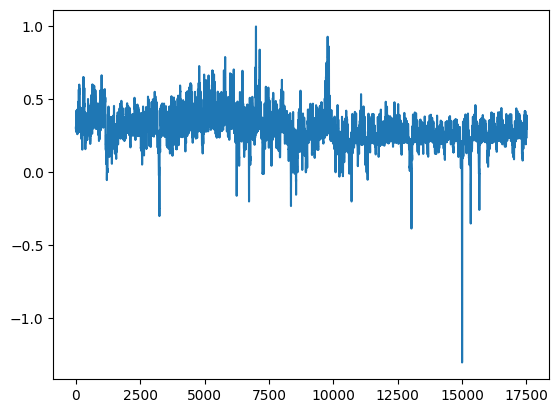

In [163]:
price_wo_leap.loc[0:17519]['Price'].plot()

<Axes: >

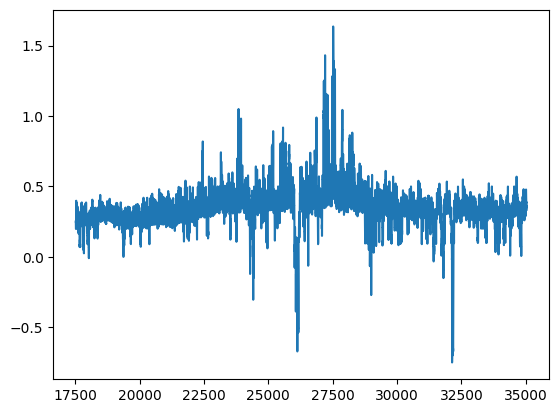

In [162]:
price_wo_leap.loc[17520:35039]['Price'].plot()

<Axes: >

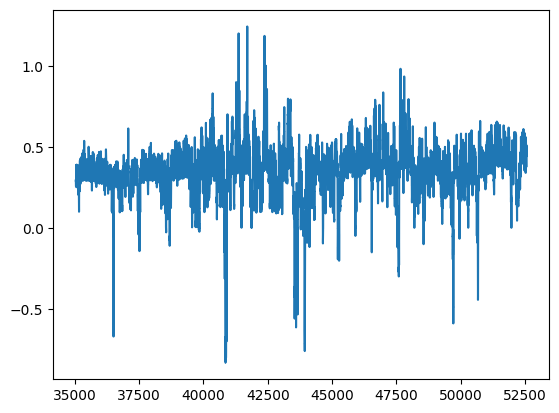

In [161]:
price_wo_leap.loc[35040:52559]['Price'].plot()

## Load & PV

In [ ]:
file_paths = [
    '0_raw/2010-2011 Solar home electricity data.csv',
    '0_raw/2011-2012 Solar home electricity data.csv',
    '0_raw/2012-2013 Solar home electricity data.csv']

dataframe = pd.DataFrame()

for file_path in file_paths:
    df = pd.read_csv(file_path, header=1)

    if '2010-2011' in file_path:
        df.date = pd.to_datetime(df.date, format='%d-%b-%y')
    else:
        df.date = pd.to_datetime(df.date, format='%d/%m/%Y')
    
    if 'Row Quality' in df.columns:
        df.drop('Row Quality', axis=1, inplace=True)
    df.drop('Generator Capacity', axis=1, inplace=True)
    df.drop('Postcode', axis=1, inplace=True)

    # Append the modified dataframe to the list
    dataframe = pd.concat([dataframe, df], ignore_index=True)

energy = {}
start = datetime(2010, 7, 1, 0, 30)
end = datetime(2013, 7, 1, 0, 0)
dates = pd.date_range(start, end, freq='30min')
energy['Date'] = dates

for customer in dataframe['Customer'].unique():
    df = dataframe[dataframe['Customer'] == customer]
    melted = df.melt(id_vars=['Customer','Consumption Category','date'],  var_name='time', value_name='value')
    melted['time'] = melted['time'].replace('0:00', '24:00')
    melted['datetime'] = pd.to_datetime(melted["date"] + pd.to_timedelta(melted['time']+':00'))

    df_load = melted[melted["Consumption Category"].isin(["GC", "CL"])].copy()
    df_load.drop("Customer",axis=1, inplace=True)
    df_load_grouped = df_load.groupby(["datetime"])["value"].sum()

    df_pv = melted[melted["Consumption Category"].isin(["GG"])].copy()
    df_pv.drop("Customer",axis=1, inplace=True)
    df_pv_grouped = df_pv.groupby(["datetime"])["value"].sum()
    
    energy[f'load_{customer}'] = pd.Series(df_load_grouped.values).round(3)
    energy[f'pv_{customer}'] = pd.Series(df_pv_grouped.values).round(3)
    energy[f'prosumption_{customer}'] = pd.Series(df_load_grouped.values - df_pv_grouped.values).round(3)
pd.DataFrame(energy).to_csv('1_processed/energy.csv', index=False)